In [2]:
import numpy as np
import matplotlib.pyplot as plt


# Импортируем библиотеку для работы с электронными таблицами pandas
import pandas as pd
!pip install xgboost
!pip install lazypredict
# Импортируем необходимые нам модули библиотеки машинного обучения sklearn
from sklearn.model_selection import train_test_split # модуль разбиения на данные для обучения и для проверки
from sklearn.preprocessing import MinMaxScaler # модуль для кодирования матрицы признаков
from lazypredict.Supervised import LazyRegressor # класс для поиска наилучшей модели для данного набора данных
from sklearn.linear_model import LinearRegression # модуль для обучения методом линейной регрессии
from sklearn.neural_network import MLPRegressor # модуль для обучения с помощью нейронной сети
from xgboost import XGBRegressor # модуль для обучения с помощью градиентного бустинга
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # методы оценки ошибки модели
from useful_fun import plot_true_vs_predicted
from sklearn.ensemble import HistGradientBoostingRegressor

In [3]:
filepath = 'datalastversion.txt'

# Посмотрим что в этом файле есть (выведем в консоль первые 7 его строк):
with open(filepath, 'r') as f:
    pure_data = f.readlines()
for i in range (0, 7):
    print (pure_data[i])

Tempering_time_(s) Tempering_temperature_(ºC) C(%wt) Mn(%wt) P(%wt) S(%wt) Si(%wt) Ni(%wt) Cr(%wt) Mo(%wt) V(%wt) Al(%wt) Cu(%wt) Final_hardness_(HRC)_post_tempering

600 204.4 0.25 0.79 0.012 0.026 0.11 0 0 0 0 0 0 50.6

600 260 0.25 0.79 0.012 0.026 0.11 0 0 0 0 0 0 48.3

600 315.6 0.25 0.79 0.012 0.026 0.11 0 0 0 0 0 0 43.7

600 371.1 0.25 0.79 0.012 0.026 0.11 0 0 0 0 0 0 40.5

600 426.7 0.25 0.79 0.012 0.026 0.11 0 0 0 0 0 0 37.3

600 482.2 0.25 0.79 0.012 0.026 0.11 0 0 0 0 0 0 31.2



In [4]:

# Нам нужно, на всякий случай, иметь под рукой переменную с именами колонок:
column_names = pure_data[0].split()  # выбираем первую строки и разбиваем на слова (названия колонок)
# смотрим, что получилось
column_names

['Tempering_time_(s)',
 'Tempering_temperature_(ºC)',
 'C(%wt)',
 'Mn(%wt)',
 'P(%wt)',
 'S(%wt)',
 'Si(%wt)',
 'Ni(%wt)',
 'Cr(%wt)',
 'Mo(%wt)',
 'V(%wt)',
 'Al(%wt)',
 'Cu(%wt)',
 'Final_hardness_(HRC)_post_tempering']

In [5]:
# Теперь преобразуем данные в массив NumPy
data = [] # пустой список, куда будем копировать данные из списка pure_data построчно, предварительно
            # их разделив и преобразовав из текстовых в числовые (типа float)
for line in pure_data[1:]:  # пропускаем заголовок
    line = line.strip() # убираем все "пробельные" символы с концов строки — то есть в начале и в конце, но не посередине.
    if line:  # если строка не пустая
        row = [float(x) for x in line.split()] #  разбиваем строку на части и возвращает ее в виде списка
        data.append(row) # записываем список row в список data
data = np.array(data) # преобразовываем список data в массив NumPy
# перемешиваем строки в массиве данных, что-бы исключить упорядоченность
np.random.seed(42) # устанавливаем фиксированный случайный набор для разбиения (что бы результаты у нас были повторяемыми)
np.random.shuffle(data) # перемешиваем строки
print (data[0:2, :])

[[7.920e+04 4.822e+02 4.100e-01 5.700e-01 1.700e-02 5.000e-03 2.400e-01
  1.700e-01 1.570e+00 3.600e-01 0.000e+00 1.260e+00 0.000e+00 4.360e+01]
 [3.600e+03 5.933e+02 4.400e-01 7.900e-01 2.000e-02 3.000e-02 2.400e-01
  2.000e-02 2.000e-02 1.000e-02 0.000e+00 0.000e+00 0.000e+00 2.470e+01]]


In [6]:
# Нам нужно разбить массив data на массив с признаками и вектор целевой переменной (твердость после закалки)
# Обозначим массив с признаками через X, а вектор целевой перменнной через y
X = data[:, :-1]
y = data[:, -1]
# Посмотрим, что получилось
print (X[:5])

[[7.920e+04 4.822e+02 4.100e-01 5.700e-01 1.700e-02 5.000e-03 2.400e-01
  1.700e-01 1.570e+00 3.600e-01 0.000e+00 1.260e+00 0.000e+00]
 [3.600e+03 5.933e+02 4.400e-01 7.900e-01 2.000e-02 3.000e-02 2.400e-01
  2.000e-02 2.000e-02 1.000e-02 0.000e+00 0.000e+00 0.000e+00]
 [9.000e+02 4.000e+02 3.100e-01 5.200e-01 7.000e-03 2.600e-02 1.000e-01
  0.000e+00 1.500e-02 0.000e+00 0.000e+00 0.000e+00 6.000e-02]
 [1.440e+04 7.044e+02 3.100e-01 5.700e-01 8.000e-03 2.500e-02 9.000e-02
  2.000e-02 2.000e-02 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [3.600e+03 3.711e+02 4.500e-01 7.300e-01 1.700e-02 3.000e-02 1.700e-01
  1.000e-02 2.000e-02 1.000e-02 0.000e+00 0.000e+00 0.000e+00]]


In [7]:
# Оценим влияние того или иного признака из имеющейся выборки на твердость с помощью коэффициента Пирсона
correlations = []
for i in range(X.shape[1]):
    corr = np.corrcoef(X[:, i], y)[0, 1]  # корреляция между i-м признаком и y
    correlations.append(corr)

# Посмотрим на результаты: чем выше модуль числа, тем более значимым является признак
for name, corr in zip(column_names[:-1], correlations):
    print(f"{name}: {corr:.3f}")
# Близко к 1 → сильная положительная связь,
# Близко к -1 → сильная отрицательная связь,
# Близко к 0 → нет линейной связи.

Tempering_time_(s): -0.180
Tempering_temperature_(ºC): -0.869
C(%wt): 0.367
Mn(%wt): -0.131
P(%wt): -0.012
S(%wt): -0.178
Si(%wt): 0.074
Ni(%wt): -0.091
Cr(%wt): 0.184
Mo(%wt): -0.021
V(%wt): 0.002
Al(%wt): 0.027
Cu(%wt): 0.113


In [53]:
# Переведем массив X в кодированный масштаб (от 0 до 1, где 0 - минимально возможное значение признака, а 1 - максимально возможное)
X_scaled = (X - X.min(axis = 0))/(X.max(axis = 0) - X.min(axis = 0))
# нужно добавить в начало столбец с 1 для расчета свобобного члена:
X_scaled = np.concatenate([np.ones((X_scaled.shape[0], 1)), X_scaled], axis=1)

# Далее нам нужно разбить данные на данные для обучения и данные для проверки получившейся модели
splitting_point = int(y.shape[0]*0.8) # предполагаем, что 80% данных мы пустим на обучение и 20% на проверку резульатов
X_train, X_test = X_scaled[:splitting_point, :], X_scaled[splitting_point:, :]
y_train, y_test = y[:splitting_point], y[splitting_point:]

# коэффициенты линейного уравнения определяются аналитически по формуле (потом добавлю)
phi = np.linalg.inv(X_train.T@X_train)@X_train.T@y_train
phi

array([ 55.802103  ,  -8.72181064, -41.42658576,  14.41026783,
         4.36371936,   4.39781344,  -1.36052883,   8.6478894 ,
         2.20265746,   4.87448474,   3.58098062,   4.02400069,
         0.16051597,   0.95883119])

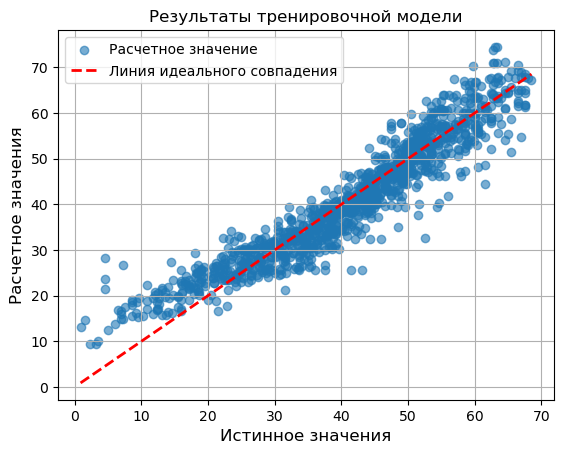

In [54]:
# расчитаем модельные значения
y_train_model =X_train@phi
y_test_model =X_test@phi
# Расчитаем коэффициент детерминации (R²) для тестовой выборки
ss_res = np.sum((y_test - y_test_model) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2 = 1 - (ss_res / ss_tot)
plt.scatter(y_train, y_train_model, alpha=0.6, label='Расчетное значение')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--', lw=2, label='Линия идеального совпадения')
plt.xlabel('Истинное значения', fontsize=12)
plt.ylabel('Расчетное значения', fontsize=12)
plt.title('Результаты тренировочной модели')
plt.grid(True)
plt.legend()

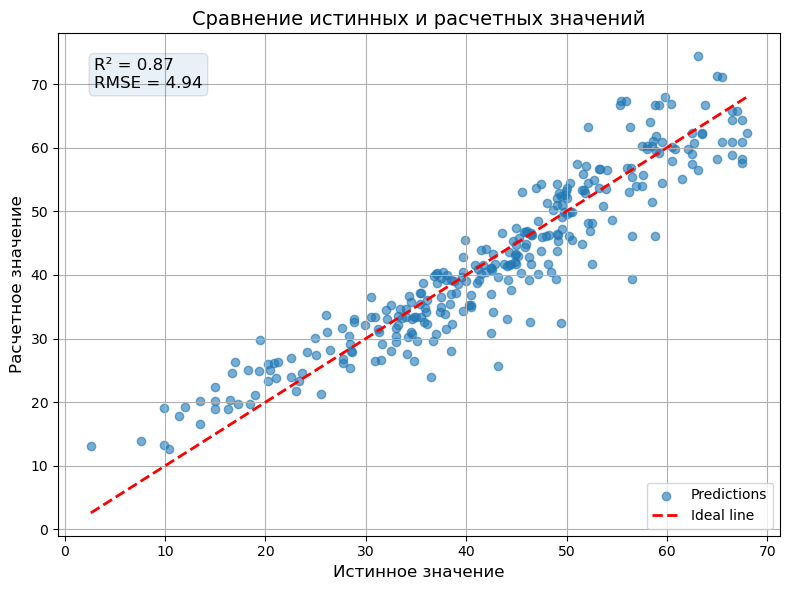

In [55]:
plot_true_vs_predicted (y_test, y_test_model)

In [56]:
# Создаём нейросеть
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),   # два скрытых слоя: 64 и 32 нейрона (попробуйте (128, 64, 32))
    activation='relu', # возможные варианты ['relu', 'tanh', 'logistic', 'identity']
    solver='adam', # возможные варианты ['adam', 'sgd', 'lbfgs', ]
    max_iter=10000,
    random_state=42,
    early_stopping=True,           # остановка при отсутствии улучшения
    validation_fraction=0.1        # часть данных для валидации
)

# Обучение
mlp.fit(X_train, y_train)


print(f'Количество итераций: {len(mlp.validation_scores_)}, последний R² = {mlp.validation_scores_[-1]:2f}')

Количество итераций: 205, последний R² = 0.941231


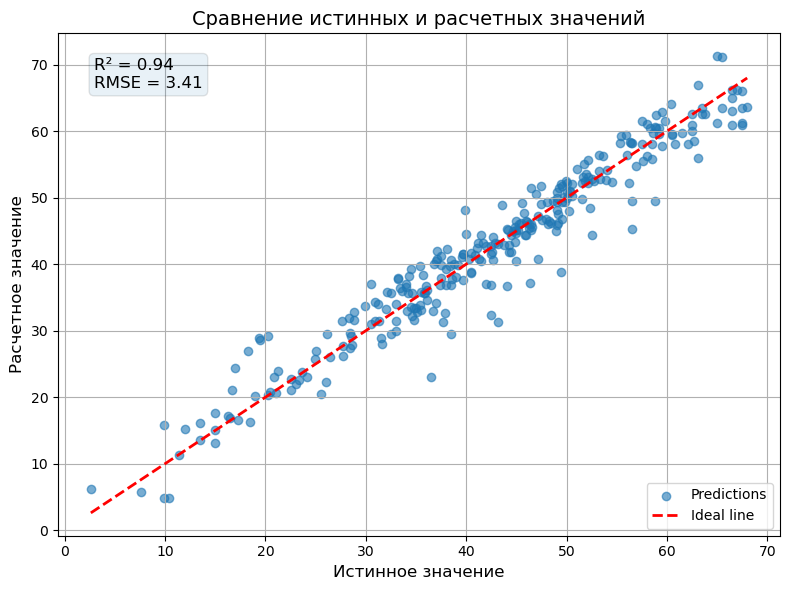

In [57]:
# Расчитываем отклик по данным для проверки
y_pred = mlp.predict(X_test)
# посмотрим на результат
plot_true_vs_predicted (y_test, y_pred)



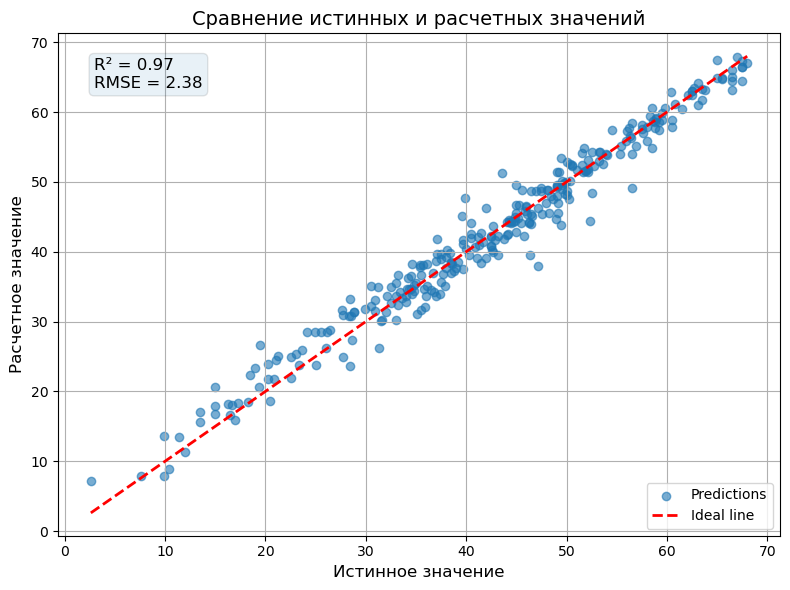

In [58]:
# Создаём модель
model = XGBRegressor(
                    n_estimators=100,
                    max_depth=2,
                    learning_rate=0.1,
                    reg_alpha=0.5,
                    reg_lambda=0.5,
                    subsample=0.8,
                    random_state=42,
                    verbosity=0
                    )
model.fit(X_train, y_train);
# Расчитываем отклик по данным для проверки
y_pred1 = model.predict(X_test)
# посмотрим на результат
plot_true_vs_predicted (y_test, y_pred1)

In [59]:
# попробуем найти модель подходящую для нашего набора данных
# Создаём и запускаем LazyRegressor
reg = LazyRegressor(
    verbose=0,            # 0 — тихо, 1 — показывает прогресс
    ignore_warnings=True, # игнорировать предупреждения (например, от моделей, которые не сходятся)
    custom_metric=None    # можно добавить свою метрику, но по умолчанию — R²
)

In [60]:
# Обучение и предсказание
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Вывод результатов
print(models)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 1172, number of used features: 13
[LightGBM] [Info] Start training from score 41.229522
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
HistGradientBoostingRegressor                0.99       0.99   1.44   
LGBMRegressor                                0.99       0.99   1.44   
XGBRegressor                                 0.99       0.99   1.63   
GradientBoostingRegressor                    0.98       0.98   1.93   
RandomForestRegressor                        0.97       0.98   2.16   
ExtraTreesRegressor                          0.97       0.97   2.18   
BaggingRegressor           

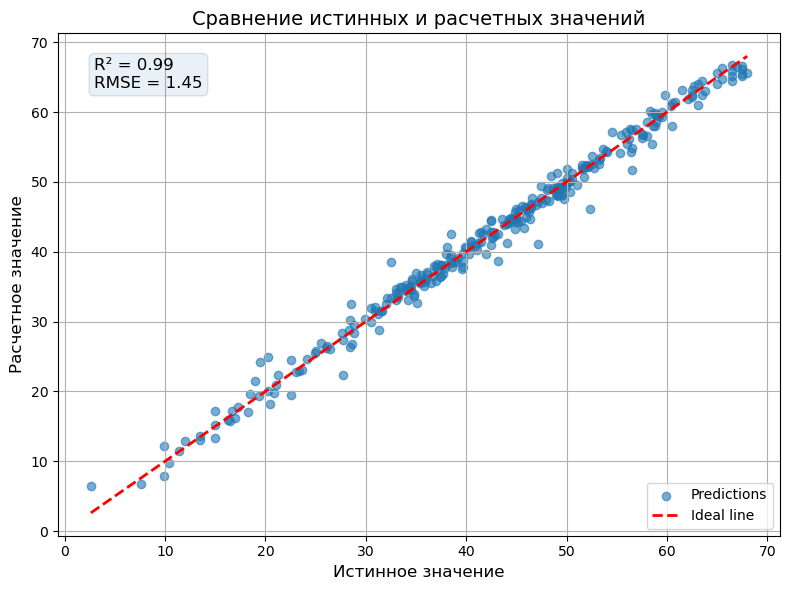

In [61]:
hgb_model = HistGradientBoostingRegressor(
    # Основные параметры
    max_iter=300,           # Количество итераций (деревьев)
    max_depth=None,         # Автоматически определит глубину
    learning_rate=0.1,      # Стандартная скорость обучения

    # Регуляризация
    l2_regularization=0.0,  # L2 регуляризация
    min_samples_leaf=20,    # Минимум образцов в листе

    # Остановка
    early_stopping=True,    # Ранняя остановка
    validation_fraction=0.1, # Доля для валидации
    n_iter_no_change=10,    # Остановка после 10 итераций без улучшений

    # Производительность
    max_bins=255,           # Количество бинов для гистограмм

    random_state=42,
    verbose=0
)

hgb_model.fit(X_train, y_train)
# Расчитываем отклик по данным для проверки
y_pred2 = hgb_model.predict(X_test)
# посмотрим на результат
plot_true_vs_predicted (y_test, y_pred2)

In [62]:
from tabulate import tabulate
models = [
    ['Линейная регрессия', 0.87, 4.94],
    ['На основе нейронной сети', 0.94, 3.41],
    ['На основе градиентного бустинга', 0.97, 2.38],
    ['На основе градиентного бустинга от scikit-learn', 0.99, 1.45]
]

headers = ['Модель', 'R²', 'RMSE']

# Красивый вывод в консоль

print(tabulate(models, headers=headers, tablefmt='psql'))

+-------------------------------------------------+------+--------+
| Модель                                          |   R² |   RMSE |
|-------------------------------------------------+------+--------|
| Линейная регрессия                              | 0.87 |   4.94 |
| На основе нейронной сети                        | 0.94 |   3.41 |
| На основе градиентного бустинга                 | 0.97 |   2.38 |
| На основе градиентного бустинга от scikit-learn | 0.99 |   1.45 |
+-------------------------------------------------+------+--------+


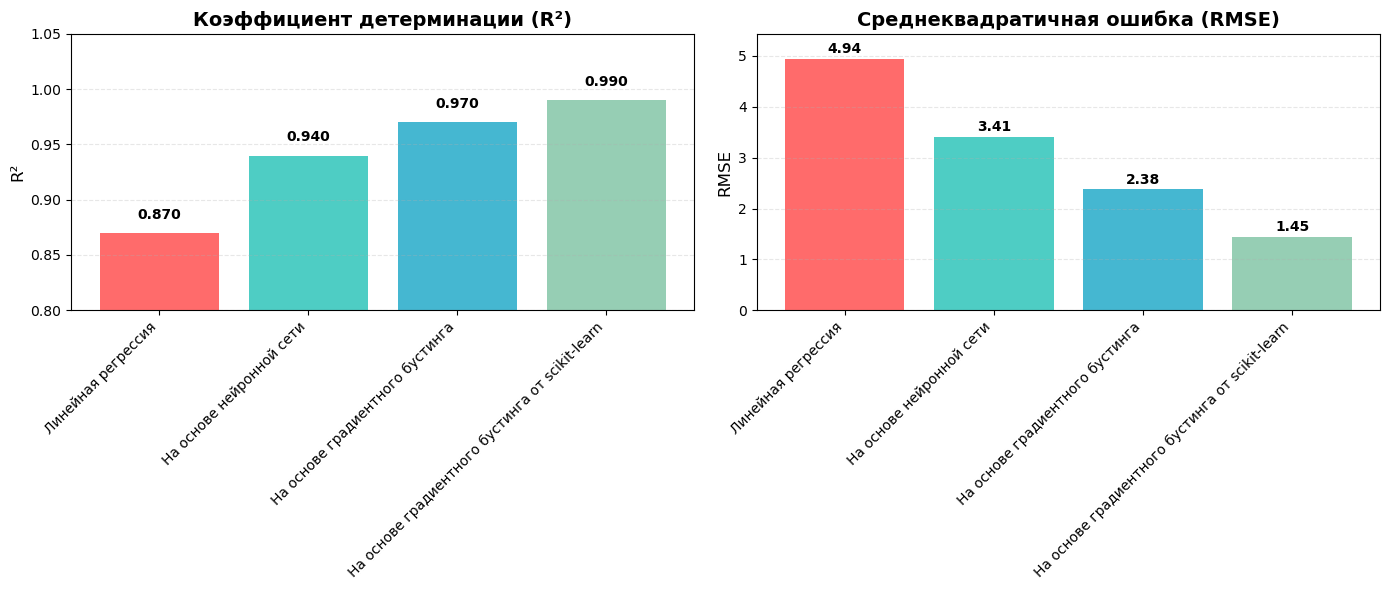

In [64]:
# Данные
models_data = [
    ['Линейная регрессия', 0.87, 4.94],
    ['На основе нейронной сети', 0.94, 3.41],
    ['На основе градиентного бустинга', 0.97, 2.38],
    ['На основе градиентного бустинга от scikit-learn', 0.99, 1.45]
]

# Извлекаем данные
models = [item[0] for item in models_data]
r2_scores = [item[1] for item in models_data]
rmse_scores = [item[2] for item in models_data]

# 1. Барчарты сравнения
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Барчарт для R²
bars1 = ax1.bar(models, r2_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax1.set_title('Коэффициент детерминации (R²)', fontsize=14, fontweight='bold')
ax1.set_ylabel('R²', fontsize=12)
ax1.set_ylim(0.8, 1.05)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения на столбцы
for bar, value in zip(bars1, r2_scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Барчарт для RMSE
bars2 = ax2.bar(models, rmse_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax2.set_title('Среднеквадратичная ошибка (RMSE)', fontsize=14, fontweight='bold')
ax2.set_ylabel('RMSE', fontsize=12)
ax2.set_ylim(0, max(rmse_scores) * 1.1)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения на столбцы
for bar, value in zip(bars2, rmse_scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

# Поворачиваем подписи для лучшей читаемости
for ax in [ax1, ax2]:
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.tick_params(axis='x', labelsize=10)

plt.tight_layout()
plt.show()

TypeError: 'numpy.ndarray' object is not callable

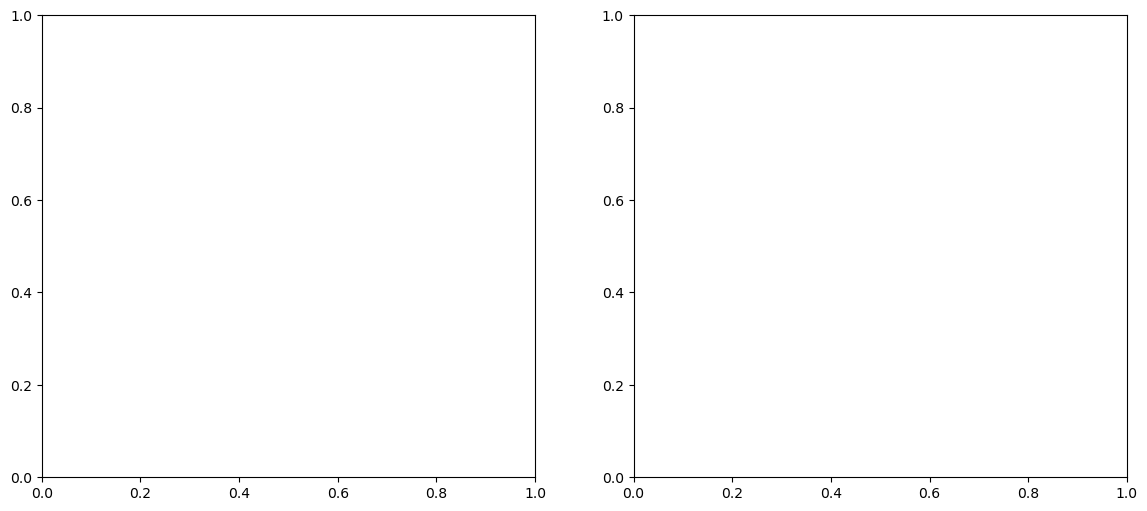

In [69]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Подготовка данных
models = list(predictions.keys())
model_predictions = list(predictions.values())

def update(frame):
    ax1.clear()
    ax2.clear()
    
    # Выбираем модель для отображения
    model_idx = frame % len(models)
    current_model = models[model_idx]
    current_pred = model_predictions[model_idx]
    
    # Левый график: график паритета
    plot_true_vs_predicted(y_test, current_pred, title=f"{current_model}", show=False)
    
    # Правый график: сравнение ошибок
    errors = np.abs(y_test - current_pred)
    ax2.hist(errors, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(x=np.mean(errors), color='red', linestyle='--', linewidth=2, 
                label=f'Среднее: {np.mean(errors):.2f}')
    ax2.axvline(x=np.median(errors), color='green', linestyle='--', linewidth=2,
                label=f'Медиана: {np.median(errors):.2f}')
    ax2.set_xlabel('Абсолютная ошибка')
    ax2.set_ylabel('Частота')
    ax2.set_title(f'Распределение ошибок: {current_model}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Общий заголовок
    fig.suptitle(f'Сравнение моделей: {current_model}\n' 
                f'R² = {1 - np.sum((y_test - current_pred)**2) / np.sum((y_test - np.mean(y_test))**2):.3f} '
                f'| MAE = {np.mean(errors):.3f}', fontsize=14, fontweight='bold')

# Создаем анимацию
ani = FuncAnimation(fig, update, frames=len(models), interval=2000, repeat=True)

# Для Jupyter
HTML(ani.to_jshtml())

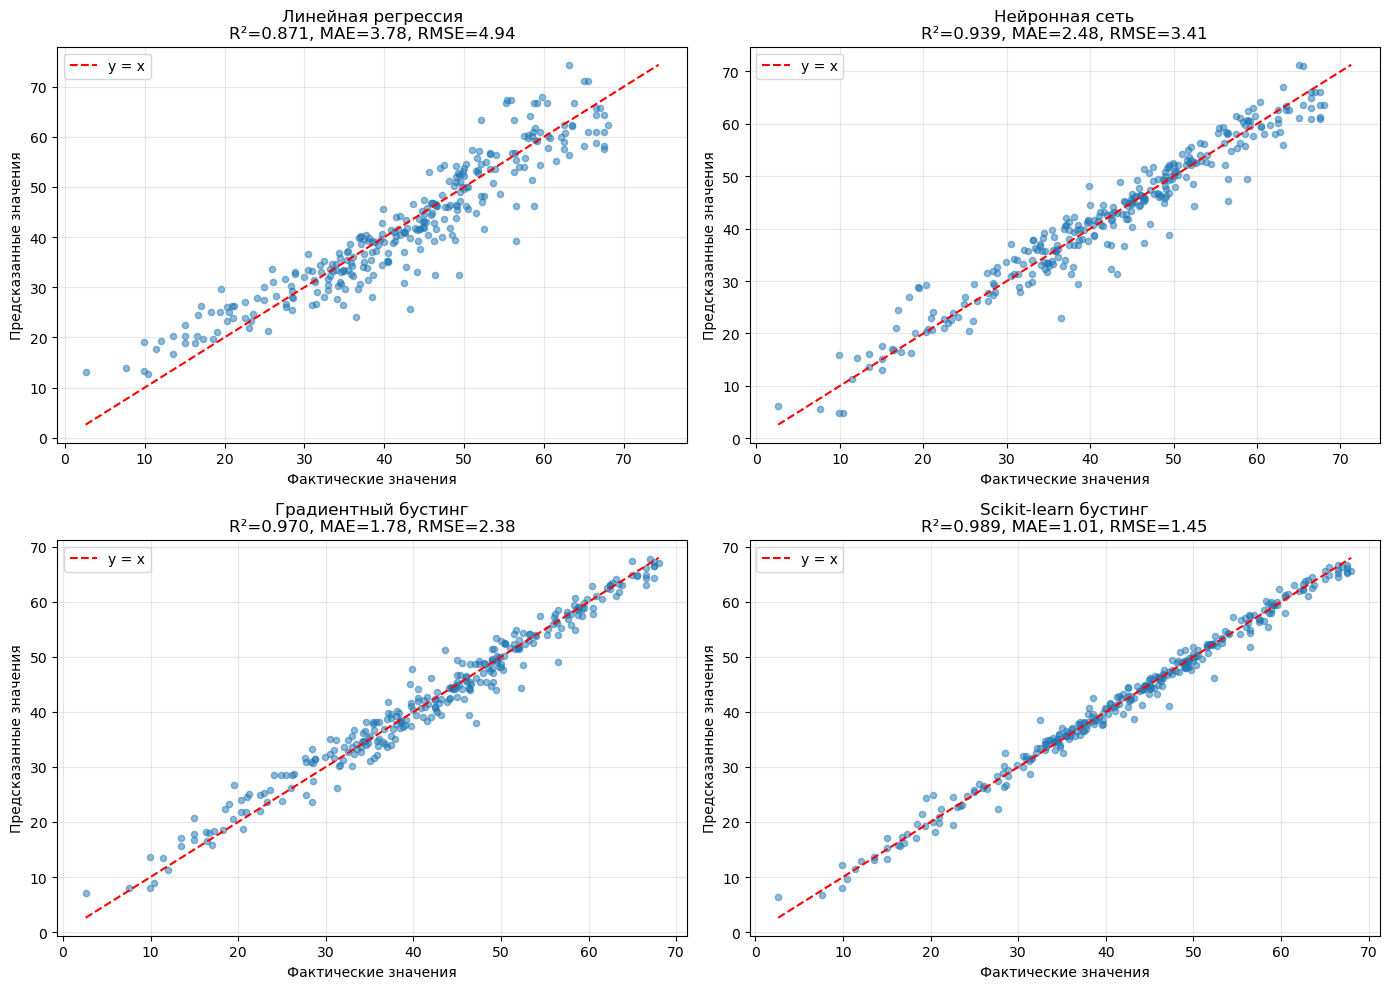


РАЗНИЦА МЕЖДУ МОДЕЛЯМИ:
Линейная регрессия             vs Нейронная сеть                : средняя разница = 2.5672
Линейная регрессия             vs Градиентный бустинг           : средняя разница = 3.3710
Линейная регрессия             vs Scikit-learn бустинг          : средняя разница = 3.6532
Нейронная сеть                 vs Градиентный бустинг           : средняя разница = 2.3013
Нейронная сеть                 vs Scikit-learn бустинг          : средняя разница = 2.3652
Градиентный бустинг            vs Scikit-learn бустинг          : средняя разница = 1.5599


In [70]:
# Самый простой способ - вывести все графики паритета рядом
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models_info = [
    ("Линейная регрессия", y_test_model),
    ("Нейронная сеть", y_pred),
    ("Градиентный бустинг", y_pred1),
    ("Scikit-learn бустинг", y_pred2)
]

for idx, (model_name, y_pred_model) in enumerate(models_info):
    ax = axes[idx // 2, idx % 2]
    
    # Используем вашу функцию или строим аналогично
    ax.scatter(y_test, y_pred_model, alpha=0.5, s=20)
    
    # Линия идеального предсказания
    min_val = min(y_test.min(), y_pred_model.min())
    max_val = max(y_test.max(), y_pred_model.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')
    
    # Метрики
    r2 = 1 - np.sum((y_test - y_pred_model)**2) / np.sum((y_test - np.mean(y_test))**2)
    mae = np.mean(np.abs(y_test - y_pred_model))
    rmse = np.sqrt(np.mean((y_test - y_pred_model)**2))
    
    ax.set_xlabel('Фактические значения')
    ax.set_ylabel('Предсказанные значения')
    ax.set_title(f'{model_name}\nR²={r2:.3f}, MAE={mae:.2f}, RMSE={rmse:.2f}')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

# Дополнительно: показываем разницу в предсказаниях
print("\n" + "="*70)
print("РАЗНИЦА МЕЖДУ МОДЕЛЯМИ:")
print("="*70)

for i in range(len(models_info)):
    for j in range(i+1, len(models_info)):
        model1_name, pred1 = models_info[i]
        model2_name, pred2 = models_info[j]
        avg_diff = np.mean(np.abs(pred1 - pred2))
        print(f"{model1_name:30} vs {model2_name:30}: средняя разница = {avg_diff:.4f}")

print("="*70)